In [1]:
# pip install pandas numpy scikit-learn matplotlib yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import randint, uniform

from graphing import graph_normal, show_results, graph_line
from results import get_num_correct_direction_difference
from get_data import get_apple_stock_split , get_recent_apple_stock_split

In [3]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

DAYS_LAG = 20

X_train, X_test, y_train, y_test = get_apple_stock_split(DAYS_LAG)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_Y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_Y.transform(y_test)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Training samples: 1772, Testing samples: 444


<h1> GridSearch setup </h1>

In [4]:
# Define the different hyperparameters
param_dist = {
    'learning_rate': uniform(0.01, 0.3),           # Shrinks the contribution of each tree
    'max_iter': randint(100, 500),                 # Number of boosting rounds
    'max_depth': randint(3, 10),                   # Maximum depth of trees
    'min_samples_leaf': randint(10, 50),           # Minimum number of samples at a leaf node
    'l2_regularization': uniform(0.0, 1.0),         # L2 regularization to prevent overfitting
    'max_bins': randint(128, 256),                 # Number of bins for histogram binning
    'scoring': ['loss', 'neg_root_mean_squared_error']
}

In [5]:
#training
model = HistGradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    cv=3,                       # cross-validation
    scoring='neg_mean_squared_error',         # Use mse as scoring
    verbose=4,
    n_jobs=-1,
    n_iter=100,  # <- increase this number for more fits
)

# Perform grid search on training data
grid_search.fit(X_train, y_train.ravel())

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [6]:
show_results(grid_search.cv_results_)

Rank 1:
Parameters: {'l2_regularization': np.float64(0.6040762215611126), 'learning_rate': np.float64(0.013738386045000009), 'max_bins': 230, 'max_depth': 3, 'max_iter': 125, 'min_samples_leaf': 45, 'scoring': 'loss'}
Mean Test Score: -1.0179
Std Dev of Test Score: 0.0807
------------------------------
Rank 2:
Parameters: {'l2_regularization': np.float64(0.12376552914296457), 'learning_rate': np.float64(0.011109891082172122), 'max_bins': 206, 'max_depth': 3, 'max_iter': 433, 'min_samples_leaf': 40, 'scoring': 'neg_root_mean_squared_error'}
Mean Test Score: -1.0646
Std Dev of Test Score: 0.0571
------------------------------
Rank 3:
Parameters: {'l2_regularization': np.float64(0.974008605411971), 'learning_rate': np.float64(0.013734209139572642), 'max_bins': 219, 'max_depth': 5, 'max_iter': 235, 'min_samples_leaf': 33, 'scoring': 'loss'}
Mean Test Score: -1.0684
Std Dev of Test Score: 0.0827
------------------------------
Rank 4:
Parameters: {'l2_regularization': np.float64(0.2063748460

In [7]:
# use best model to predict test data
final_model = grid_search.best_estimator_

# Predict on test data
predictions = scaler_Y.inverse_transform(final_model.predict(X_test).reshape(-1,1))
actual = scaler_Y.inverse_transform(y_test)

mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)

print(f"Final Model RMSE: {rmse}")
print(f"Final Model MAE: {mae}")

Final Model RMSE: 1.731490234068504
Final Model MAE: 0.982796564519457


[*********************100%***********************]  1 of 1 completed

RMSE: 3.1569929532466263
MAE: 2.388517247990997


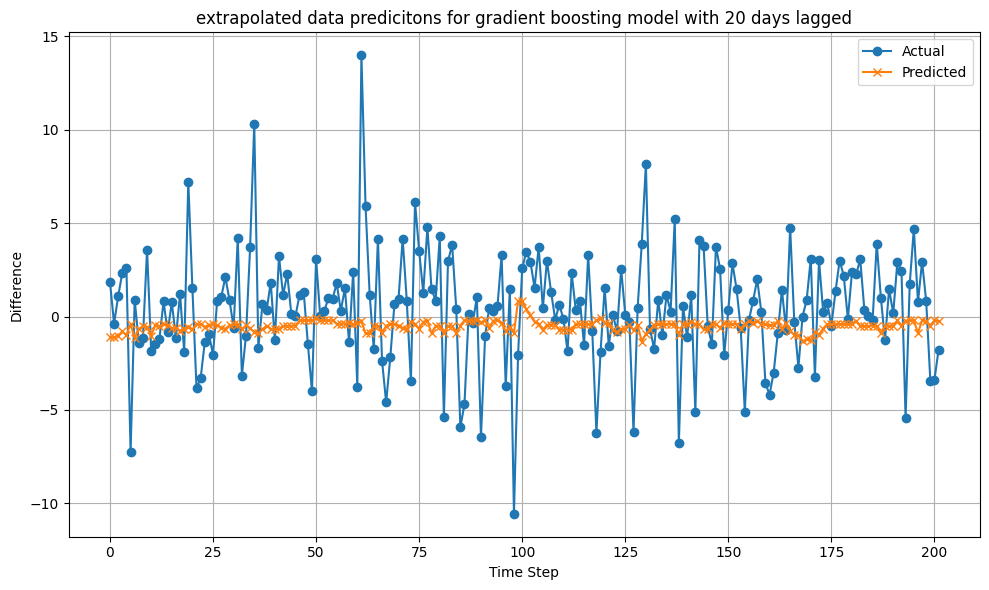

Price   Ticker
Target            79
dtype: int64 correct directions out of a total: 202


/mnt/c/Users/kenan/dev/university_final_year_project/venv_linux/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Price   Ticker
Target            79
dtype: int64

In [8]:
# trying to predict more recent ones
X, y = get_recent_apple_stock_split(DAYS_LAG)


X_scaled = scaler_X.transform(X)
predictions = scaler_Y.inverse_transform(grid_search.best_estimator_.predict(X_scaled).reshape(-1,1))

mae = mean_absolute_error(y, predictions)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
#graph_normal(predictions, y, "recent data predicitons")
graph_line(predictions, y, f"extrapolated data predicitons for gradient boosting model with {DAYS_LAG} days lagged")
get_num_correct_direction_difference(predictions,y)